# Importing Libraries

In [1]:
!pip install swifter
!pip install modin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.0/647.0 KB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for swifter: filename=swifter-1.1.3-py3-none-any.whl size=13078 sha256=84492000ecc390de1d504d232a6e57bfd2520b2e766be62c53618d37368171e1
  Stored in directory: /root/.cache/pip/wheels/e8/1a/1b/46aa7b0fac16d3ce1bccaac14bfe4fad972642217ae78d8160
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.5/761.5 KB 2.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import modin.pandas as md
import swifter
import re
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.functional as f
import torchtext.vocab as Vocab
from collections import Counter, OrderedDict
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pad_packed_sequence
import pytorch_lightning as pl
from tqdm import tqdm_notebook
import spacy
import torch
import os
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import random
# RANDOM_SEED = 2023
# def seed_everything(seed=RANDOM_SEED):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True    
# seed_everything()
%matplotlib inline

# Dataset

In [3]:
data = pd.read_csv("../input/news-summary/news_summary_more.csv",encoding = 'unicode_escape')

In [4]:
# data = data.dropna(subset=['ctext']).reset_index()

In [5]:
df = data.copy()
df = data.rename(columns = {'text':'body','headlines':'issue_title'})

# Utils

In [6]:
def text_cleaner(text):
    """
    cleans the tex
    """
    text = text.lower()
    #Replacing with urls
    text = re.sub(r"\S*https?:\S*", "url", text)
    #Replacing html text
    text = re.sub(r"<.*?>", "html", text)
    #Replacing Special chars
    text = re.sub(r"[^a-zA-Z0-9]+"," ",text)
    #Replacing numeric
    text = " ".join(["" if t.isnumeric() else t for t in text.split(" ")])
    return text

def token_maker(text,m):
    #Creating tokens
    doc = m(text)
    return [token.text for token in doc if token.text not in [" "]]

In [7]:
display(df.head())

#Cleaning both X, y
df['issue_title'] = df['issue_title'].swifter.apply(lambda x: text_cleaner(x))
df['body'] = df['body'].swifter.apply(lambda x: text_cleaner(x))
display(df.tail())

#Loading spacy tokenizer
m = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 


#Max len and add sos and eos,y
df['issue_title'] = df['issue_title'].swifter.apply(lambda x: token_maker(x,m))
df['issue_title'] = df['issue_title'].swifter.apply(lambda x: ['<sos>'] +x)
df['issue_title'] = df['issue_title'].swifter.apply(lambda x: x[:min(20,len(x))]+['<eos>'])
display(df.tail())

,issue_title,body
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


Pandas Apply:   0%|          | 0/98401 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98401 [00:00<?, ?it/s]

,issue_title,body
98396,crpf jawan axed to death by maoists in chhatti...,a crpf jawan was on tuesday axed to death with...
98397,first song from sonakshi sinha s noor titled u...,uff yeh the first song from the sonakshi sinh...
98398,the matrix film to get a reboot reports,according to reports a new version of the sci...
98399,snoop dogg aims gun at clown dressed as trump ...,a new music video shows rapper snoop dogg aimi...
98400,madhesi morcha withdraws support to nepalese g...,madhesi morcha an alliance of seven political ...


Pandas Apply:   0%|          | 0/98401 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98401 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98401 [00:00<?, ?it/s]

,issue_title,body
98396,"[<sos>, crpf, jawan, axed, to, death, by, maoi...",a crpf jawan was on tuesday axed to death with...
98397,"[<sos>, first, song, from, sonakshi, sinha, s,...",uff yeh the first song from the sonakshi sinh...
98398,"[<sos>, the, matrix, film, to, get, a, reboot,...",according to reports a new version of the sci...
98399,"[<sos>, snoop, dogg, aims, gun, at, clown, dre...",a new music video shows rapper snoop dogg aimi...
98400,"[<sos>, madhesi, morcha, withdraws, support, t...",madhesi morcha an alliance of seven political ...


In [8]:
df.tail()

,issue_title,body
98396,"[<sos>, crpf, jawan, axed, to, death, by, maoi...",a crpf jawan was on tuesday axed to death with...
98397,"[<sos>, first, song, from, sonakshi, sinha, s,...",uff yeh the first song from the sonakshi sinh...
98398,"[<sos>, the, matrix, film, to, get, a, reboot,...",according to reports a new version of the sci...
98399,"[<sos>, snoop, dogg, aims, gun, at, clown, dre...",a new music video shows rapper snoop dogg aimi...
98400,"[<sos>, madhesi, morcha, withdraws, support, t...",madhesi morcha an alliance of seven political ...


In [9]:
#Tokenizing X
df['body'] = df['body'].swifter.apply(lambda x: token_maker(x,m))
display(df.tail())

Pandas Apply:   0%|          | 0/98401 [00:00<?, ?it/s]

,issue_title,body
98396,"[<sos>, crpf, jawan, axed, to, death, by, maoi...","[a, crpf, jawan, was, on, tuesday, axed, to, d..."
98397,"[<sos>, first, song, from, sonakshi, sinha, s,...","[uff, yeh, the, first, song, from, the, sonaks..."
98398,"[<sos>, the, matrix, film, to, get, a, reboot,...","[according, to, reports, a, new, version, of, ..."
98399,"[<sos>, snoop, dogg, aims, gun, at, clown, dre...","[a, new, music, video, shows, rapper, snoop, d..."
98400,"[<sos>, madhesi, morcha, withdraws, support, t...","[madhesi, morcha, an, alliance, of, seven, pol..."


In [10]:
df['body_len'] = df['body'].swifter.apply(lambda x: len(x))
df['body'] = df.swifter.apply(lambda x: x['body'][:min(100,x['body_len'])],axis=1)
display(df.tail())

Pandas Apply:   0%|          | 0/98401 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98401 [00:00<?, ?it/s]

,issue_title,body,body_len
98396,"[<sos>, crpf, jawan, axed, to, death, by, maoi...","[a, crpf, jawan, was, on, tuesday, axed, to, d...",62
98397,"[<sos>, first, song, from, sonakshi, sinha, s,...","[uff, yeh, the, first, song, from, the, sonaks...",59
98398,"[<sos>, the, matrix, film, to, get, a, reboot,...","[according, to, reports, a, new, version, of, ...",57
98399,"[<sos>, snoop, dogg, aims, gun, at, clown, dre...","[a, new, music, video, shows, rapper, snoop, d...",58
98400,"[<sos>, madhesi, morcha, withdraws, support, t...","[madhesi, morcha, an, alliance, of, seven, pol...",61


In [11]:
#building the covab
v1 = Vocab.build_vocab_from_iterator(df['body'],min_freq=10,specials=['<unk>','<sos>','<eos>','<pad>'])
v2 = Vocab.build_vocab_from_iterator(df['issue_title'],min_freq=10,specials=['<unk>','<sos>','<eos>','<pad>'])
# v2 = v1
len(v1),len(v2)

(20961, 8837)

In [12]:
v2.set_default_index(v2['<unk>'])
v1.set_default_index(v1['<unk>'])

In [13]:
len(v1),len(v2)

(20961, 8837)

In [14]:
vocabulary1 = v1.get_stoi()
vocabulary2 = v2.get_stoi()

df['issue_title'] = df['issue_title'].swifter.apply(lambda x: [v2[token] for token in x])
df['body'] = df['body'].swifter.apply(lambda x: [v1[token] for token in x])

Pandas Apply:   0%|          | 0/98401 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98401 [00:00<?, ?it/s]

In [15]:
import json
with open('body_vocab.json', 'w') as fp:
    json.dump(vocabulary1, fp)
with open('title_vocab.json', 'w') as fp:
    json.dump(vocabulary2, fp)

In [16]:
display(df.head())

,issue_title,body,body_len
0,"[1, 6097, 0, 0, 4, 764, 5, 0, 1727, 11, 1111, ...","[0, 6738, 29, 7892, 8, 9851, 9, 10966, 1457, 1...",61
1,"[1, 32, 3914, 169, 234, 345, 17, 3430, 7, 125,...","[4573, 331, 10, 1455, 1160, 609, 1623, 550, 0,...",61
2,"[1, 43, 1316, 360, 522, 543, 513, 10, 6, 167, ...","[81, 894, 862, 34, 19, 820, 7, 4, 721, 414, 27...",58
3,"[1, 8342, 190, 0, 1843, 521, 962, 1688, 827, 3...","[20, 17645, 228, 20394, 1919, 851, 845, 69, 40...",58
4,"[1, 60, 2283, 3231, 7, 137, 149, 87, 1234, 178...","[436, 57, 4, 450, 760, 587, 53, 4638, 4632, 15...",63


In [17]:
len(vocabulary1),len(vocabulary2)

(20961, 8837)

# Dataset Class

In [18]:
class github_class(Dataset):
    
    def __init__(self,dataset):
        self.dataset = dataset
        
    def __getitem__(self,idx):
        X = self.dataset.loc[idx]
        #X
        x = torch.tensor(X['body'])
        
        #y
        y = X['issue_title']
        y_inp = torch.tensor(y[:-1])
        y_op = torch.tensor(y[1:])
        
        return x,y_inp,y_op

    def __len__(self):
        return len(self.dataset)
    
def collate_fnc(batch):
    
    X,y_inp,y_op = zip(*batch)
    
    X_lens = [len(x) for x in X]
    y_inp_lens = [len(y) for y in y_inp]
    y_op_lens = [len(y) for y in y_op]
    
    X = pad_sequence(X,batch_first=True, padding_value=3)
    y_inp = pad_sequence(y_inp,batch_first=True, padding_value=3)
    y_op = pad_sequence(y_op,batch_first=True, padding_value=3)
    
    return X, y_inp, y_op, X_lens, y_inp_lens, y_op_lens
    
    
    

In [19]:
# v1['<pad>']

In [20]:
from torch.utils.data import random_split
git_issue = github_class(df)
train_dataset, val_dataset = random_split(git_issue,[int(0.8*len(df)), len(df) - int(0.8*len(df))])

In [21]:
train_dataloader = DataLoader(train_dataset,batch_size=8,collate_fn = collate_fnc)
val_dataloader = DataLoader(val_dataset,batch_size=8,collate_fn = collate_fnc)

In [22]:
class Encoder(nn.Module):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_size,
                 enc_hidden_size,
                 enc_out_size,
                 lstm_layers,
                 dropout):
    
        super(Encoder,self).__init__()
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.lstm_layers = lstm_layers
        self.enc_hidden_size = enc_hidden_size
        self.enc_out_size = enc_out_size
        self.dropout = dropout
        
        
        self.emb = nn.Embedding(self.vocabulary_size,self.embedding_size,padding_idx =3)

        self.rnn = nn.LSTM(
                          input_size= self.embedding_size,
                          hidden_size=self.enc_hidden_size,
                          num_layers = self.lstm_layers,
                          batch_first = True,
                          dropout = self.dropout,
                          bidirectional = True
                          )
        self.normer = nn.LayerNorm(self.embedding_size)
        self.lin = nn.Linear(2*self.enc_hidden_size,self.enc_out_size)
        self.droper = nn.Dropout(p=0.5)
        self.droper1 = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        self.normalizer = nn.LayerNorm(self.enc_out_size)
        
    def forward(self,x_pad,h=None,c=None):
        
        # Gegtting the input for the encoder and length that can be
        # used for pack and unpack the sequence 
        # x -> (B, L)
        x , x_lens = x_pad
        
        #batch size for initializing the hidden layer
        btc = x.size(0)
        
        # Embedding for the input
        # x -> (B,L) to (B,L,EMB)
        x = self.droper(self.emb(x.long()))
        
        # packing before entering in the encoder lstm
        x = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        
        # If not provided initially then initialize randomly
        if h==None:
            h = torch.rand((self.lstm_layers*2,btc,self.enc_hidden_size)).to('cuda')
            c = torch.rand((self.lstm_layers*2,btc,self.enc_hidden_size)).to('cuda')
        
        # passed through then encoder
        output, (h1,c1) = self.rnn(x,(h,c))
        
        # Unpack the output
        output, output_lengths = pad_packed_sequence(output, batch_first=True)
        
        # passing through linear layer
        # 
        output = self.lin(self.droper1(output))
        
        output = self.normalizer(output)
            
        # Giving out the output of the encoder and hidden states of encoder
        return output, h1, c1
        
    

In [23]:
# torch.rand((2,10,123))[:,-1,:].shape

In [24]:
class Attention(nn.Module):
    
    def __init__(self,
                 encoder_output_size,
                 decoder_hidden_state_size,
                 att_midsize,
                ):
        
        super(Attention,self).__init__()
        
        self.encoder_output_size = encoder_output_size
        self.decoder_hidden_state_size = 2*decoder_hidden_state_size
        self.att_midsize = att_midsize
        
        self.enc_mid_sizer = nn.Linear(encoder_output_size,self.att_midsize)
        self.dec_mid_sizer = nn.Linear(2*decoder_hidden_state_size,self.att_midsize)
        
        self.scorer = nn.Linear(self.att_midsize,1)
        
        self.tanh_act = nn.Tanh()
        
        self.softmaxer = nn.Softmax(dim=1)
        self.normalizer = nn.LayerNorm(self.att_midsize)
        
    
    def forward(self,encoder_out, decoder_state):
                
        encoder_mid = self.enc_mid_sizer(encoder_out)
#         print('encoder_mid',encoder_mid.shape,'decoder_state',decoder_state.shape)
        if decoder_state.shape[1]==2:
            
            b = torch.cat((decoder_state[:,0,:].unsqueeze(1),decoder_state[:,1,:].unsqueeze(1)),dim=-1)
            decoder_mid = self.dec_mid_sizer(b)
#             print(b.shape)
            
        else:
            decoder_mid = self.dec_mid_sizer(decoder_state)
            
#         print(encoder_mid.shape,decoder_mid.shape)
        
        add_mid = encoder_mid + decoder_mid
        
#         add_mid = self.normalizer(add_mid)
        
        add_mid = self.tanh_act(add_mid)
    
        scores = self.scorer(add_mid)
       
        scores = self.softmaxer(scores)
        
        return scores.squeeze(-1)

In [25]:
class Decoder(nn.Module):
    
    def __init__(self,
                encoder_output_size,
                decoder_hidden_state_size,
                att_mid_size,
                input_size_decoder,
                embedding_size_decoder,
                vocabulary_size,
                decoder_lstm_layers,
                decoder_dropout
                ):
        
        super(Decoder,self).__init__()
        
        self.encoder_output_size = encoder_output_size
        self.decoder_hidden_state_size = decoder_hidden_state_size
        self.att_mid_size = att_mid_size
        
        self.input_size_decoder = input_size_decoder
        self.embedding_size_decoder = embedding_size_decoder
        self.vocabulary_size = vocabulary_size
        
        self.decoder_lstm_layers = decoder_lstm_layers
        self.decoder_dropout = decoder_dropout
        
        self.attention = Attention(
                                    encoder_output_size,
                                    decoder_hidden_state_size,
                                    att_mid_size
        )
        self.decoder_embedding = nn.Embedding(self.vocabulary_size,self.input_size_decoder,padding_idx=3)
        self.context_size = self.encoder_output_size + self.input_size_decoder
        
        self.decoder_rnn = nn.LSTM(
                          input_size= self.context_size,
                          hidden_size= 2*self.decoder_hidden_state_size,
                          num_layers = self.decoder_lstm_layers,
                          batch_first = True,
                          dropout = self.decoder_dropout
                          )
        self.normer = nn.LayerNorm(self.context_size)
        self.lin = nn.Linear(2*self.decoder_hidden_state_size,self.vocabulary_size)
        self.droper = nn.Dropout(p=0.5)
        self.droper1 = nn.Dropout(p=0.3)
        
    def forward(self, encoder_ouput, decoder_prev_state, decoder_input):
        
#         decoder_input_pack = decoder_input, decoder_input_lens
        
#         decoder_input = pack_padded_sequence(decoder_input, 
#                                              decoder_input_lens, 
#                                              batch_first=True, 
#                                              enforce_sorted=False)
        
        h, c = decoder_prev_state
        h1 = h.permute(1,0,2)
        
        
        scores = self.attention(encoder_ouput,h1)
        
#         print(scores.shape)
                
        context = torch.bmm(scores.unsqueeze(1),encoder_ouput)
#         print('context',context.shape)
        
        decoder_input = self.droper(self.decoder_embedding(decoder_input.long()))
#         print('decoder_input',decoder_input.shape)

        context_input = torch.cat((context,decoder_input),dim=-1)
#         print('context_input',context_input.shape)
#         print('hc',h.shape,c.shape)
        if h.shape[0] ==2:
            bh= torch.cat((h[0,:,:].unsqueeze(0),h[1,:,:].unsqueeze(0)),dim=-1)
            bc = torch.cat((c[0,:,:].unsqueeze(0),c[1,:,:].unsqueeze(0)),dim=-1)
            output_decoder, decoder_hidden = self.decoder_rnn(context_input, 
                                                              (bh,bc))
        else:
            output_decoder, decoder_hidden = self.decoder_rnn(context_input, 
                                                              (h,c))
                                                        
#         print('output_decoder',output_decoder.shape)
        
#         output_decoder = self.lin(output_decoder)
        output_decoder = self.lin(self.droper1(output_decoder))
        return output_decoder,decoder_hidden,scores

            
        

In [26]:
# class EncoderDecoder(nn.Module):
    
#     def __init__(
#                     self,
#                     encoder,
#                     decoder,
# #                     decoder_hidden_size,
# #                     vocabulary_decoder_size
                    
#                 ):
        
#         super(EncoderDecoder,self).__init__()
        
#         self.encoder = encoder
#         self.decoder = decoder
        
        
#     def forward(
#                 self,
#                 loader
#                ):
        
#         X, y_inp, y_op, x_lens, y_inp_lens, y_op_lens = loader
        
        
        
#         encoder_output, h1, c1 = self.encoder((X,x_lens))
        
#         output = []

#         for i in range(y_inp.shape[1]):
            
# #             print(y_inp[:,i].unsqueeze(1),'y_inp')

#             o, (h1,c1) = self.decoder(encoder_output,(h1,c1),y_inp[:,i].unsqueeze(1))
            
#             output.append(o)
            
            

#         return torch.stack(output).permute(2,1,0,3).squeeze(0)    

In [27]:
encoder = Encoder(
                  len(vocabulary1),
                  embedding_size=256,
                  enc_hidden_size=512,
                  enc_out_size= 256,
                  lstm_layers=1,
                  dropout=0.2
                )
decoder = Decoder(
                encoder_output_size= 256,
                decoder_hidden_state_size = 512,
                att_mid_size = 256 ,
                input_size_decoder = 256,
                embedding_size_decoder = 256,
                vocabulary_size = len(vocabulary2) ,
                decoder_lstm_layers = 1,
                decoder_dropout= 0.2
                )

In [28]:
import pytorch_lightning as pl

class git_model(pl.LightningModule):
    
    def __init__(self,encoder,decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.loss = nn.CrossEntropyLoss(ignore_index=3)
        
    def forward(self, loader):
        X, y_inp, y_op, x_lens, y_inp_lens, y_op_lens = loader
        
        encoder_output, h1, c1 = self.encoder((X,x_lens))
#         print(encoder_output.shape)
        output = []
        
        for i in range(y_inp.shape[1]):
            
            o, (h1,c1),scores = self.decoder(encoder_output,(h1,c1),y_inp[:,i].unsqueeze(1))
            
            output.append(o)
        return torch.stack(output).permute(2,1,0,3).squeeze(0) 
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4*5)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        X, y_inp, y_op, x_lens, y_inp_lens, y_op_lens = train_batch
        
        out = self(train_batch)
        out = out.reshape(-1,len(vocabulary2))  
        
        label = y_op.reshape(-1)
        loss = self.loss(out, label.long())

        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y_inp, y_op, x_lens, y_inp_lens, y_op_lens = val_batch
        
        out = self(val_batch)
        out = out.reshape(-1,len(vocabulary2))  
        
        label = y_op.reshape(-1)
        loss = self.loss(out, label.long())
        
        self.log('val_loss', loss)
        
        
# training
model_class = git_model(encoder,decoder)
earystopping = EarlyStopping(monitor="val_loss")




In [29]:
loss_checkpoint = callbacks.ModelCheckpoint(
            filename="best_loss",
            monitor="val_loss",
            save_top_k=1,
            mode="min",
            save_last=False,
        )
logger = TensorBoardLogger('git_model')

#---------------------------------------------------------------------------------------------------------
trainer = pl.Trainer(gpus=1,
                     max_epochs =50,
                     logger=logger,
                     callbacks=[earystopping,
                                loss_checkpoint],
                    precision=16,

                    )
trainer.fit(model_class, train_dataloader, val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [30]:
# os.listdir('./git_model/default/version_1/')

In [31]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from glob import glob

path = glob(f'./git_model/lightning_logs/version_0/events*')[0]
event_acc = EventAccumulator(path, size_guidance={'scalars': 0})
event_acc.Reload()

scalars = {}
for tag in event_acc.Tags()['scalars']:
    events = event_acc.Scalars(tag)
    scalars[tag] = [event.value for event in events]

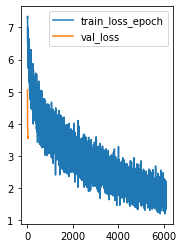

In [32]:
plt.subplot(1, 2, 2)
plt.plot(range(len(scalars['train_loss'])), scalars['train_loss'], label='train_loss_epoch')
plt.plot(range(len(scalars['val_loss'])), scalars['val_loss'], label='val_loss')

plt.legend()

In [33]:
# trainer.model.encoder

In [34]:
md = trainer.model.eval()
md = md.to('cpu')

In [35]:
i = 0
for loader in val_dataloader:
    i = i+1
    if i==6:
        break
    

In [36]:
# loader[3]

In [37]:
for i in range(64):
    for ex in range(3):
        print(ex)
        idx = i
        h = torch.rand((2*md.encoder.lstm_layers,1,md.encoder.enc_hidden_size))
        c = torch.rand((2*md.encoder.lstm_layers,1,md.encoder.enc_hidden_size))

        eo,h1,c1 = md.encoder((
                        loader[0][idx].unsqueeze(0),
                        torch.tensor([loader[3][idx]])
                                ),h,c)

        O = []
        for j in range(200):
            if j==0:
                o, (h1,c1),scores = md.decoder(eo,(h1,c1),torch.tensor([[1.]]))
    #             if torch.argmax(o,dim=-1).item() == 0:
    #                 m,n = torch.topk(o,2)
    #                 n = torch.tensor([[n[:,:,-1].item()]])    
    #             else:
    #                 n = torch.argmax(o,dim=-1)
    #             print(scores)
            else:
                o, (h1,c1),scores = md.decoder(eo,(h1,c1),torch.argmax(o[:,:,1:],dim=-1)+1)
    #             if torch.argmax(o,dim=-1).item() == 0:
    #                 m,n = torch.topk(o,2)
    #                 n = torch.tensor([[n[:,:,-1].item()]])    
    #             else:
    #                 n = torch.argmax(o,dim=-1)
    #             print(o)
            O.append(torch.argmax(o[:,:,1:],dim=-1)+1)

        output = O
    #     print(O)
        print("______________________________________issue_____________________________________________")
        print(" ".join([v1.get_itos()[k] for k in loader[0][idx]]))
        print("_______________________________________machine___________________________________________")
        print(" ".join([v2.get_itos()[k.item()] for k in output]))
        print("_______________________________________original__________________________________________")
        print(" ".join([v2.get_itos()[k.item()] for k in loader[2][idx]]))
        print("==================================================\n\n")

0
______________________________________issue_____________________________________________
a three <unk> dinosaur footprint dating back million years has been damaged in an australian park after unknown vandals <unk> it with a hammer park officials believe it was a pre planned act as vandals would have known exactly where the footprint was the <unk> was discovered in in victoria s <unk> marine national park and left in place for visitors <pad> <pad> <pad>
_______________________________________machine___________________________________________
dating park named after years with park park <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eo

IndexError: index 8 is out of bounds for dimension 0 with size 8

In [ ]:
#              else:
# #                 _,indices = torch.topk(o,dim=-1,k=2)
# # #                 print(indices)
# #                 print('h')
# #                 o = indices[:,:,1]
# #                 O.append(torch.tensor([[o.item()]]))
# # #                 print(o)
# #                 o, (h1,c1) = md.decoder(eo,(h1,c1),torch.tensor([[o.item()]]))
# #         print(o.shape)

In [ ]:
rnn = nn.LSTM(10, 20, 1,bidirectional=True,batch_first =True)
>>> input = torch.randn(3, 5, 10)
>>> h0 = torch.randn(2, 3, 20)
>>> c0 = torch.randn(2, 3, 20)
>>> output, (hn, cn) = rnn(input, (h0, c0))

In [ ]:
output.shape